# Make classification data

In [25]:
import sklearn
from sklearn.datasets import make_circles

In [26]:
# make 1000 samples of toy dataset
n_sample = 1000

X, y = make_circles(n_sample, noise=0.03, random_state=42)

In [27]:
len(X), len(y)

(1000, 1000)

In [28]:
X[:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [29]:
X[:5].shape

(5, 2)

In [30]:
y[:5]

array([1, 1, 1, 1, 0])

In [31]:
import pandas as pd

In [32]:
circles = pd.DataFrame({"X1":X[:,0], "X2":X[:,1], "label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [81]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

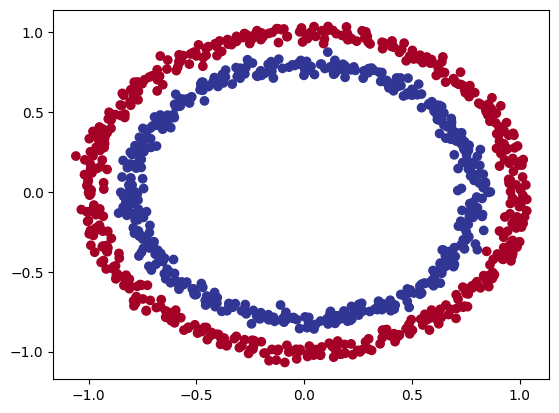

In [33]:
# visualise 
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

# check input and output shapes

In [34]:
X.shape, y.shape

((1000, 2), (1000,))

In [35]:
# view the first exampel of features and labels
X_sample = X[0]
y_sample = y[0]

print(X_sample)
print(y_sample)

[0.75424625 0.23148074]
1


In [36]:
X_sample.shape, y_sample.shape # scalar has no shape

((2,), ())

In [37]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [38]:
import torch
torch.__version__

'2.3.0'

In [39]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [40]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [41]:
type(X), type(y), X.dtype, y.dtype

(torch.Tensor, torch.Tensor, torch.float32, torch.float32)

In [44]:
torch.manual_seed(42)

In [45]:
# split dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
len(X_train), len(X_test), len(y_train), len(y_test), n_sample

(800, 200, 800, 200, 1000)

# build model to classify our red and blue circles

In [50]:
from torch import nn

# device
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(device)

mps


## Steps:

1. Subclasses nn.Module 
2. Create 2 nn.Linear layers
3. Create a forward method
4. Instantiate model and set on device

In [51]:
X_train.shape

torch.Size([800, 2])

In [57]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes 2 feature and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self,x):
        return self.layer_2(self.layer_1(x))


In [58]:
model0 = CircleModelV0().to(device)

In [60]:
model0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [63]:
model0.parameters()

<generator object Module.parameters at 0x1793f7350>

In [64]:
next(model0.parameters()).device
# model0.parameters() returns a generator/iterator of parameters (nn.Parameter objects)
# Iterators don’t have a .device attribute.

device(type='mps', index=0)

## lets replicate using nn.sequential

implements most of linear forwarding itself and we dont have to construct our own class

In [65]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.two_layers = nn.Sequential(
                            nn.Linear(in_features=2,out_features=5),
                            nn.Linear(in_features=5,out_features=1)
        )
    
    def forward(self,x):
        return self.two_layers(x)

In [70]:
model1 = CircleModelV0().to(device)

In [71]:
model1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.2976,  0.6313],
                      [ 0.4087, -0.3091],
                      [ 0.4082,  0.1265],
                      [ 0.3591, -0.4310],
                      [-0.7000, -0.2732]], device='mps:0')),
             ('layer_1.bias',
              tensor([-0.5424,  0.5802,  0.2037,  0.2929,  0.2236], device='mps:0')),
             ('layer_2.weight',
              tensor([[-0.0078,  0.3500, -0.3178,  0.0282, -0.3052]], device='mps:0')),
             ('layer_2.bias', tensor([0.1379], device='mps:0'))])

In [72]:
# make predictions with untrained params
with torch.inference_mode():
    untrained_preds = model1(X_test.to(device))

In [74]:
len(untrained_preds), untrained_preds.shape

(200, torch.Size([200, 1]))

In [75]:
untrained_preds[:10]

tensor([[0.0763],
        [0.1453],
        [0.0813],
        [0.0742],
        [0.3760],
        [0.4158],
        [0.3764],
        [0.4404],
        [0.0688],
        [0.1532]], device='mps:0')

In [76]:
y_test[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

### setup loss and optimizer

1. in loss = nn.BCELoss() You must apply sigmoid yourself 
- y_pred = torch.sigmoid(logits)
- loss = nn.BCELoss()(y_pred, y_true)
- Numerically unstable for extreme values
- Easy to forget sigmoid
- Can cause NaNs during training

2. in loss nn.BCEWithLogitsLoss() Model output: raw logits (no sigmoid)
- Internally does: sigmoid + BCE  (in one stable operation)
- Numerically stable (uses log-sum-exp trick)
- Cleaner code
- Standard for binary & multilabel tasks

In [77]:
loss_fn = nn.BCEWithLogitsLoss()

optimzer = torch.optim.SGD(params=model1.parameters(), lr=0.1)

In [ ]:
# Calculate accuracy
# scikit learn does (true,pred) but torch.loss does (pred,true)
def accuracy_fn(y_true,y_pred):
    correct = (
        torch.eq(y_true, y_pred).sum().item()
    )  # item is done to convert scalar tensor to python int

    acc = correct / len(y_pred)
    return acc*100

# Train model

1. forward pass
2. calculate loss 
3. optimzer zero grad
4. loss backwards (backprop)
5. optimizer step (gradient descent)

y_pred > 0.5 --> 1 

else 0

In [88]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# configs
epochs = 100 
# important to keep on same device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

model1 = model1.to(device)

for epoch in range(epochs): 
    # training mode
    model1.train()

    # 1. forward pass
    y_logits = model1(X_train).squeeze() # squeeze to convert to scalar from tensor
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. passing logits since BCEWithLogits expects logits
    loss = loss_fn(y_logits, y_train)

    # if we used BCE loss, expects probabilities
    # loss = loss_fn(torch.sigmoid(y_logits), y_train)

    # train accuracy
    train_acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. optimizer zero grad
    optimzer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimzer step
    optimzer.step()

    # eval mode
    model1.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)

        # acc
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0: 
        print(
            f"Epoch: {epoch} | Train Loss: {loss}, Acc: {train_acc} | Test Loss: {test_loss}, Acc: {test_acc}"
        )

Epoch: 0 | Train Loss: 0.7007598280906677, Acc: 58.5 | Test Loss: 0.7007765173912048, Acc: 55.00000000000001
Epoch: 10 | Train Loss: 0.6964245438575745, Acc: 52.0 | Test Loss: 0.697644829750061, Acc: 53.0
Epoch: 20 | Train Loss: 0.6948421001434326, Acc: 51.24999999999999 | Test Loss: 0.6965116858482361, Acc: 50.5
Epoch: 30 | Train Loss: 0.6941783428192139, Acc: 50.74999999999999 | Test Loss: 0.6959907412528992, Acc: 50.5
Epoch: 40 | Train Loss: 0.6938422918319702, Acc: 50.375 | Test Loss: 0.6956688165664673, Acc: 49.5
Epoch: 50 | Train Loss: 0.6936383247375488, Acc: 50.375 | Test Loss: 0.6954258680343628, Acc: 49.5
Epoch: 60 | Train Loss: 0.6934972405433655, Acc: 50.375 | Test Loss: 0.6952273845672607, Acc: 49.0
Epoch: 70 | Train Loss: 0.6933926343917847, Acc: 50.625 | Test Loss: 0.6950622797012329, Acc: 49.5
Epoch: 80 | Train Loss: 0.6933120489120483, Acc: 50.24999999999999 | Test Loss: 0.6949255466461182, Acc: 48.5
Epoch: 90 | Train Loss: 0.6932489275932312, Acc: 50.0 | Test Loss: 0.

# Make prediction and eval model bec only 48.5% accuracy

In [90]:
import requests
from pathlib import Path 

# download helper function
if Path("helper_functions.py").is_file():
    print("helper_functions.py exists!")
else: 
    # get "raw" version copied path
    request = requests.get(
        "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py"
    )

with open("helper_functions.py", "wb") as f: # wb: write binary
    f.write(request.content)

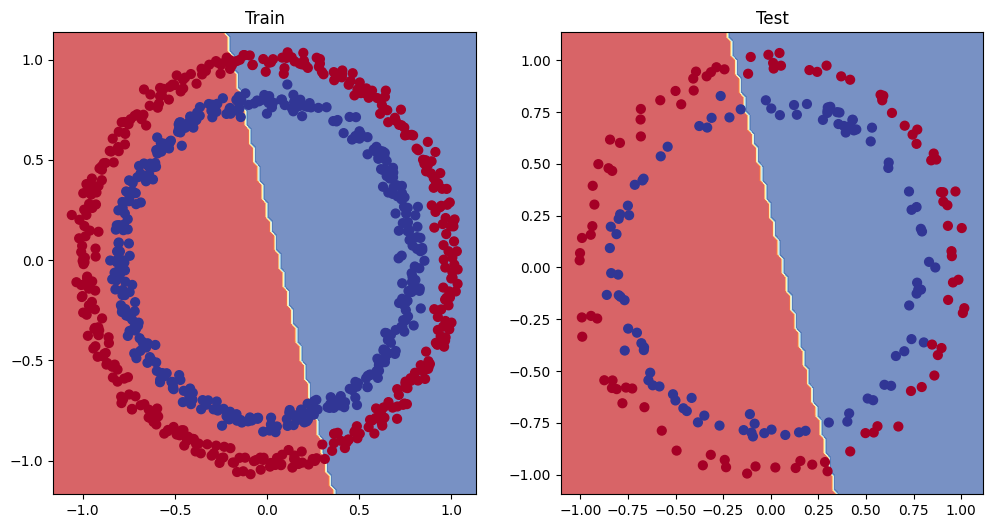

In [ ]:
from helper_functions import plot_predictions, plot_decision_boundary

# plot decision boundary of model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1) # (rows, column , index )
plt.title("Train")
plot_decision_boundary(model1,X_train,y_train)
plt.subplot(1, 2, 2)  # (rows, column , index )
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)

### linear model cant fit on non-linear data

## preparing linear data to see if it fits straight line 

assume it works

# introducing non-linearity

In [114]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(in_features=2,out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # non-linear activation 

    def forward(self,x):
        # this method improves backend optimzations
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

In [115]:
model3 = CircleModelV2().to(device)

In [116]:
loss_fn = nn.BCEWithLogitsLoss()
optimzer = torch.optim.SGD(model3.parameters(), lr=0.1)

### training loop

In [117]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# configs
epochs = 1000
X_train.to(device)
X_test.to(device)
y_train.to(device)
y_test.to(device)

for epoch in range(epochs): 

    # train mode
    model3.train()

    # 1. forward pass
    y_logits = model3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    train_acc = accuracy_fn(y_train, y_pred)

    # 2. loss calculate
    loss = loss_fn(y_logits, y_train)

    # 3. zero_grad
    optimzer.zero_grad()

    # 4. loss backwards
    loss.backward()

    # 5. optimzer step
    optimzer.step()

    model3.eval()
    with torch.inference_mode():
        test_logits = model3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 10 == 0: 
        print(f"Epoch: {epoch} | Train loss:{loss} Acc:{train_acc} | Test loss:{test_loss} Acc:{test_acc}")

Epoch: 0 | Train loss:0.6929462552070618 Acc:50.0 | Test loss:0.6931881904602051 Acc:50.0
Epoch: 10 | Train loss:0.692476212978363 Acc:50.5 | Test loss:0.6925959587097168 Acc:50.0
Epoch: 20 | Train loss:0.6922456622123718 Acc:59.12500000000001 | Test loss:0.69231116771698 Acc:56.49999999999999
Epoch: 30 | Train loss:0.6920924186706543 Acc:70.25 | Test loss:0.6921225190162659 Acc:68.0
Epoch: 40 | Train loss:0.691948413848877 Acc:68.375 | Test loss:0.6919479966163635 Acc:71.0
Epoch: 50 | Train loss:0.6918084025382996 Acc:58.25 | Test loss:0.6917727589607239 Acc:57.99999999999999
Epoch: 60 | Train loss:0.6916752457618713 Acc:54.0 | Test loss:0.691611647605896 Acc:54.50000000000001
Epoch: 70 | Train loss:0.6915476322174072 Acc:53.125 | Test loss:0.6914634704589844 Acc:53.0
Epoch: 80 | Train loss:0.6914128065109253 Acc:52.625 | Test loss:0.6913154721260071 Acc:53.0
Epoch: 90 | Train loss:0.6912803649902344 Acc:52.75 | Test loss:0.6911686062812805 Acc:53.0
Epoch: 100 | Train loss:0.691152811

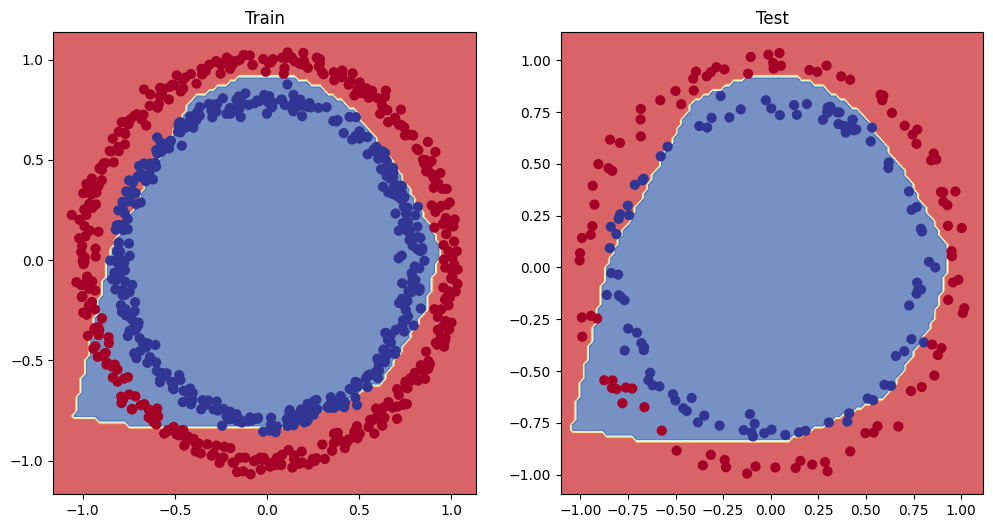

In [118]:
from helper_functions import plot_predictions, plot_decision_boundary

# plot decision boundary of model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # (rows, column , index )
plt.title("Train")
plot_decision_boundary(model3, X_train, y_train)
plt.subplot(1, 2, 2)  # (rows, column , index )
plt.title("Test")
plot_decision_boundary(model3, X_test, y_test)

### linear model cant fit on non-linear data

# replicating non-linear functions

In [119]:
A = torch.arange(-10,10,1,dtype=torch.float32)
A.dtype

torch.float32

In [120]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

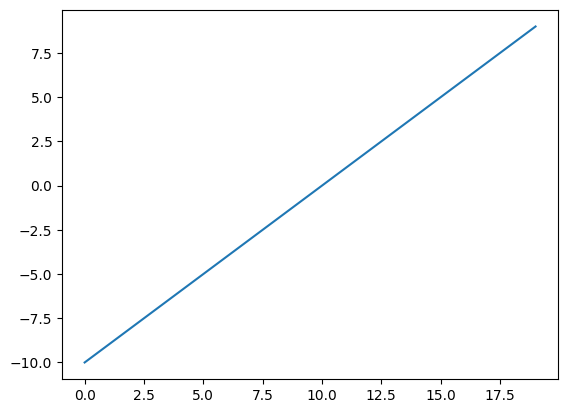

In [121]:
# visualise 
plt.plot(A)

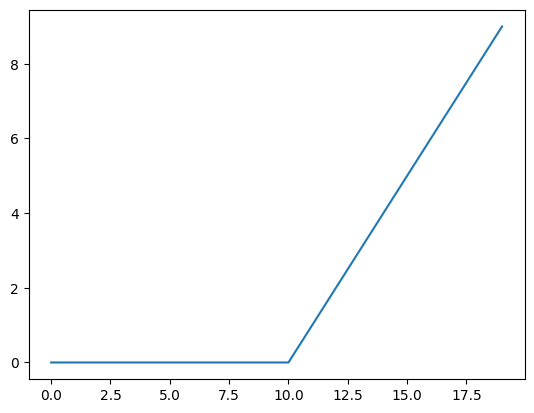

In [124]:
plt.plot(torch.relu(A))

In [126]:
def relu(x) -> torch.Tensor:
    return torch.maximum(torch.tensor(0),x) # input must be tensors

In [127]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [137]:
A = torch.arange(-10,10,dtype=torch.float32)

In [138]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

In [139]:
def sigmoid(x) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

In [140]:
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

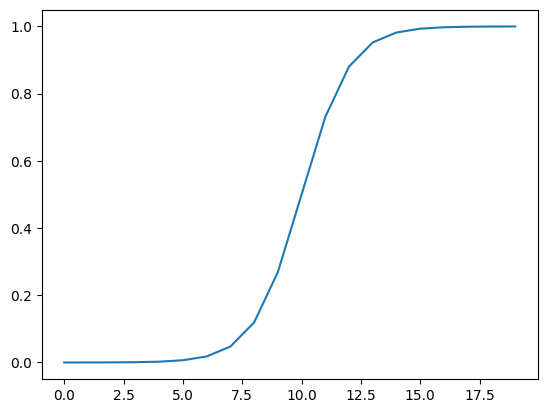

In [141]:
plt.plot(sigmoid(A))

# multi-class classification

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split # learn

# set hype-parameter
NUM_CLASS = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# create data
X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASS,
    cluster_std=1.5,
    random_state=RANDOM_SEED,
)  # cluster_std give randomness

In [ ]:
# convert to tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

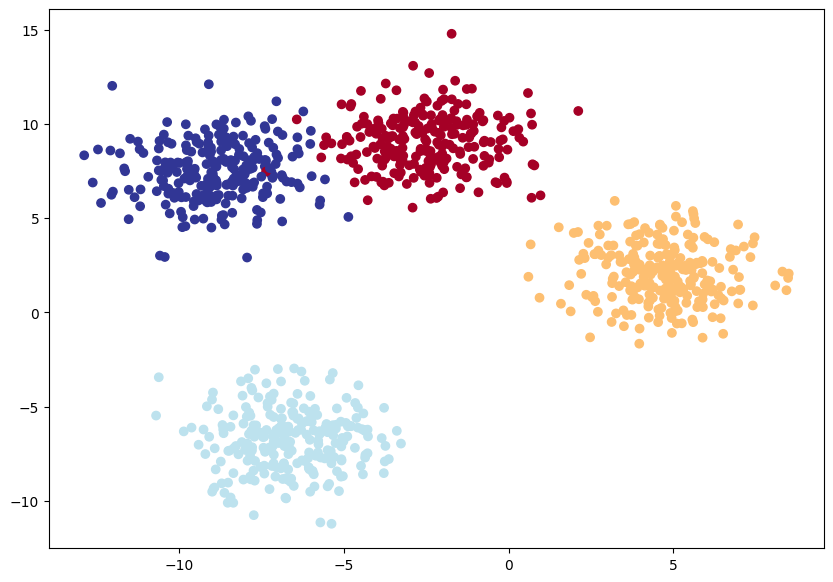

In [148]:
# visualise
plt.figure(figsize=(10,7)) # inches 
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

# Multi class model

In [ ]:
# device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(device)

In [164]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initialises multi-class model

        Args:
        input_features (int): Number of input features
        output_features (int): Number of output features
        hidden_units (int): Number of hidden layers

        Returns:

        Example:
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

In [165]:
model4 = BlobModel(2,4,8).to(device)

In [166]:
model4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [167]:
next(model4.parameters())

Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188],
        [ 0.6146,  0.1323],
        [ 0.5224,  0.0958],
        [ 0.3410, -0.0998]], device='mps:0', requires_grad=True)

In [168]:
next(model4.parameters()).device

device(type='mps', index=0)

In [169]:
# for multi classification we use cross entropy
loss_fn = nn.CrossEntropyLoss()

optimzer = torch.optim.SGD(params=model4.parameters(), lr=0.1)

logits(num_labels) -> pred prob(num_labels) --> pred labels(1) 


In [171]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# configs
epochs = 1000

# .to(device) is NOT in-place
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
model4 = model4.to(device)

for epoch in range(epochs):
    # set to train
    model4.train()

    # 1. forward pass
    y_logits = model4(X_train)

    # y_logits  # shape: [batch_size, num_classes]
    # dim=1 = operate across classes ( max across columns )
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # max across columns / dimension indexed 1 ( original dimensions : rows x columns)

    loss = loss_fn(y_logits,y_train)
    train_acc = accuracy_fn(y_train, y_pred)

    optimzer.zero_grad()
    loss.backward()
    optimzer.step()

    # Test
    model4.eval() # turns off dropout and does batch norm
    with torch.inference_mode():
        test_logits = model4(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Train loss:{loss} Acc:{train_acc} | Test loss:{test_loss} Acc:{test_acc}"
        )

Epoch: 0 | Train loss:1.1588265895843506 Acc:40.375 | Test loss:1.0755419731140137 Acc:48.0
Epoch: 10 | Train loss:0.6447554230690002 Acc:96.75 | Test loss:0.660687267780304 Acc:97.5
Epoch: 20 | Train loss:0.4253515601158142 Acc:98.5 | Test loss:0.43074119091033936 Acc:100.0
Epoch: 30 | Train loss:0.25294235348701477 Acc:99.125 | Test loss:0.2450762242078781 Acc:99.5
Epoch: 40 | Train loss:0.11232152581214905 Acc:99.25 | Test loss:0.10228518396615982 Acc:99.5
Epoch: 50 | Train loss:0.06626509875059128 Acc:99.25 | Test loss:0.05847535282373428 Acc:99.5
Epoch: 60 | Train loss:0.050680141896009445 Acc:99.25 | Test loss:0.04293225705623627 Acc:99.5
Epoch: 70 | Train loss:0.042996734380722046 Acc:99.25 | Test loss:0.03490963950753212 Acc:99.5
Epoch: 80 | Train loss:0.03836136311292648 Acc:99.25 | Test loss:0.02987818419933319 Acc:99.5
Epoch: 90 | Train loss:0.03524841368198395 Acc:99.25 | Test loss:0.02662649191915989 Acc:99.5
Epoch: 100 | Train loss:0.033122170716524124 Acc:99.25 | Test lo

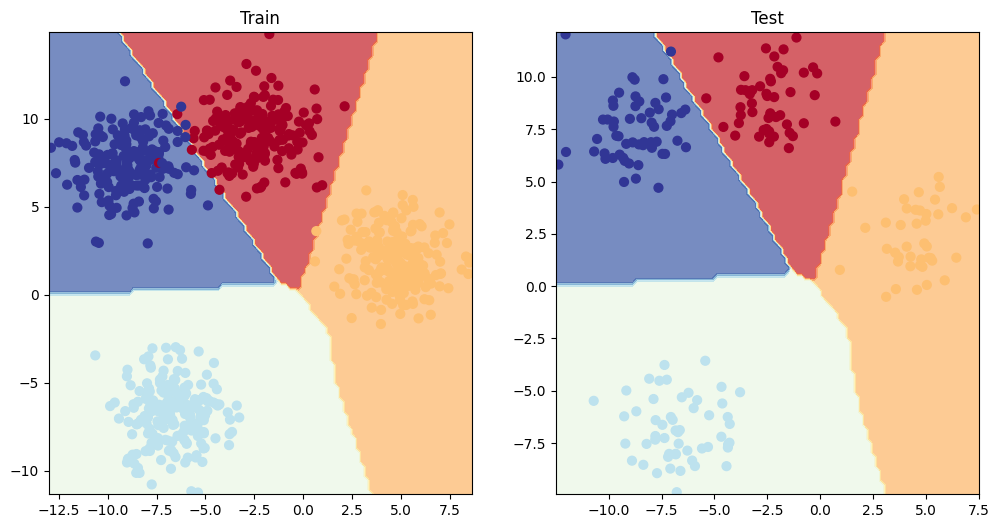

In [172]:
from helper_functions import plot_predictions, plot_decision_boundary

# plot decision boundary of model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # (rows, column , index )
plt.title("Train")
plot_decision_boundary(model4, X_train, y_train)
plt.subplot(1, 2, 2)  # (rows, column , index )
plt.title("Test")
plot_decision_boundary(model4, X_test, y_test)

# Classification metrics

1. accuracy 
2. preicion, recall, f1 
3. Confusion matrix 
4. Classification report

1. TorchMetrics
    -  Works on GPU
    - Designed for training loops
    - Stateful (needs .reset() sometimes)


2. Sklearn
    - CPU only
    - Best for final evaluation / reporting
    - Not for backprop loops


## Rule of thumb
- During training → torchmetrics
- After training / reports → sklearn

### torchmetrics

In [ ]:
# TORCHMETRICS (GPU / training-time)
# import torch
# from torchmetrics import (
#     Accuracy,
#     Precision,
#     Recall,
#     F1Score,
#     ConfusionMatrix,
# )

# C = 4  # number of classes

# tm_accuracy = Accuracy(task="multiclass", num_classes=C)
# tm_precision = Precision(task="multiclass", num_classes=C, average="macro")
# tm_recall = Recall(task="multiclass", num_classes=C, average="macro")
# tm_f1 = F1Score(task="multiclass", num_classes=C, average="macro")
# tm_confmat = ConfusionMatrix(task="multiclass", num_classes=C)

# # usage (inside training / eval loop)
# # y_pred: Tensor[int] shape [N]
# # y_true: Tensor[int] shape [N]
# acc = tm_accuracy(y_pred, y_true)
# prec = tm_precision(y_pred, y_true)
# rec = tm_recall(y_pred, y_true)
# f1 = tm_f1(y_pred, y_true)
# confmat = tm_confmat(y_pred, y_true)

# # reset when needed (e.g., end of epoch)
# tm_accuracy.reset()
# tm_precision.reset()
# tm_recall.reset()
# tm_f1.reset()
# tm_confmat.reset()

### sklearn

In [ ]:
# SKLEARN (CPU / final evaluation & reports)
# from sklearn.metrics import (
#     accuracy_score,
#     precision_score,
#     recall_score,
#     f1_score,
#     confusion_matrix,
#     classification_report,
# )

# # y_true, y_pred can be numpy arrays or lists
# sk_acc = accuracy_score(y_true, y_pred)
# sk_prec = precision_score(y_true, y_pred, average="macro")
# sk_rec = recall_score(y_true, y_pred, average="macro")
# sk_f1 = f1_score(y_true, y_pred, average="macro")
# sk_confmat = confusion_matrix(y_true, y_pred)

# print(classification_report(y_true, y_pred))